In [5]:
from html.parser import HTMLParser
import re
import pandas as pd
from tqdm import tqdm

In [6]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textstat import flesch_reading_ease
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')

ModuleNotFoundError: No module named 'textstat'

In [ ]:
# Load dataset
df = pd.read_csv("/Users/srinija/Desktop/seo-content-detector_2448526/data/data.csv")

In [ ]:
print(f"Loaded dataset with {len(df)} rows.")

Loaded dataset with 81 rows.


In [ ]:
df.shape

(81, 2)

In [ ]:
df.sample(4)

,url,html_content
71,https://en.wikipedia.org/wiki/Artificial_intel...,"<!DOCTYPE html>\n<html class=""client-nojs vect..."
18,https://www.hpe.com/us/en/what-is/sd-wan.html,NaN
56,https://www.woot.com/,\r\n\r\n\r\n <!DOCTYPE html>\r\n <html>\...
17,https://www.fortinet.com/resources/cyberglossa...,"\n <!doctype html>\n <html lang=""en"">\n ..."


In [ ]:
df.isnull().sum()

url              0
html_content    12
dtype: int64

# identity the null values and remove them from the dataset

In [ ]:
missing_html = df[df['html_content'].isnull()]
print("Rows with missing html_content:")
print(missing_html)

# Then remove them
df = df.dropna(subset=['html_content']).reset_index(drop=True)


Rows with missing html_content:
                                                  url html_content
4   https://www.qnbtrust.bank/Resources/Learning-C...          NaN
12  https://www.connectwise.com/blog/phishing-prev...          NaN
18      https://www.hpe.com/us/en/what-is/sd-wan.html          NaN
20  https://support.microsoft.com/en-us/windows/ho...          NaN
23  https://www.cloudflare.com/learning/access-man...          NaN
40  https://towardsdatascience.com/machine-learnin...          NaN
41  https://www.analyticsvidhya.com/blog/2021/09/c...          NaN
51       https://www.investopedia.com/terms/s/seo.asp          NaN
55  https://www.dollardays.com/?srsltid=AfmBOopXjd...          NaN
75  https://www.reuters.com/technology/artificial-...          NaN
76      https://www.cnbc.com/artificial-intelligence/          NaN
77       https://www.bbc.com/news/topics/c404v061z99t          NaN


In [ ]:
df.shape

(69, 2)

In [ ]:
print(f"Loaded dataset with {len(df)} rows.") # from the previous 81 to 69

Loaded dataset with 69 rows.


In [ ]:
# using the HTMLPARSER

In [ ]:
#  Custom HTML parser
class MyHTMLParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.text = []

    def handle_data(self, data):
        self.text.append(data)


#  Extraction function
def extract_text_builtin(html_text):
    parser = MyHTMLParser()
    parser.feed(str(html_text))
    full_text = ' '.join(parser.text)
    full_text = re.sub(r'\s+', ' ', full_text).strip()   # Clean whitespace
    word_count = len(full_text.split())

    # Extract <title> using regex
    match = re.search(r'<title>(.*?)</title>', str(html_text), re.IGNORECASE | re.DOTALL)
    title = match.group(1).strip() if match else "Untitled"

    return title, full_text, word_count


#  Apply parsing to each row
parsed_rows = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    html = row['html_content']
    title, body_text, wc = extract_text_builtin(html)
    parsed_rows.append({
        "url": row['url'],
        "title": title,
        "body_text": body_text,
        "word_count": wc
    })


# 5 Convert to DataFrame and save
parsed_df = pd.DataFrame(parsed_rows)
parsed_df.to_csv("../data/extracted_content_htmlparser.csv", index=False)

print("Extraction complete! File saved as: data/extracted_content.csv")
print(parsed_df.head(7))



100%|██████████| 69/69 [00:01<00:00, 52.41it/s]

Extraction complete! File saved as: data/extracted_content.csv
                                                 url  \
0     https://www.cm-alliance.com/cybersecurity-blog   
1    https://www.varonis.com/blog/cybersecurity-tips   
2  https://www.cisecurity.org/insights/blog/11-cy...   
3  https://www.cisa.gov/topics/cybersecurity-best...   
4  https://nordlayer.com/learn/network-security/b...   
5  https://www.fortinet.com/resources/cyberglossa...   
6  https://www.cisco.com/site/us/en/learn/topics/...   

                                               title  \
0                                Cyber Security Blog   
1  Top 10 Cybersecurity Awareness Tips: How to St...   
2  11 Cyber Defense Tips to Stay Secure at Work a...   
3  Cybersecurity Best Practices | Cybersecurity a...   
4     Network Security 101: Understanding the Basics   
5  What Is Network Security? Definition and Types...   
6                  What Is Network Security? - Cisco   

                                       

# 2. Text Preprocessing & Feature Engineering (25%)


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/srinija/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/srinija/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srinija/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
df_extracted = pd.read_csv("../data/extracted_content.csv")

#  cleaning the text
def clean_text(text):
    text = text.lower()                           # remove the lowercase
    text = re.sub(r'\s+', ' ', text)              # remove extra whitespa e
    text = re.sub(r'[^a-z0-9.,;:!?\'"()\- ]+', '', text)  # keep alphanumeric + punctuation
    return text.strip()

df_extracted['clean_text'] = df_extracted['body_text'].apply(clean_text)

#  feature engineering
stop_words = set(stopwords.words('english'))

def extract_features(text):
    # for the sentence and word counts
    sentences = sent_tokenize(text)
    words = [w for w in word_tokenize(text) if w.isalnum() and w not in stop_words]
    sentence_count = len(sentences)
    word_count = len(words)
    
    # readability score
    try:
        readability = flesch_reading_ease(text)
    except:
        readability = 0.0

    return pd.Series({
        "word_count": word_count,
        "sentence_count": sentence_count,
        "flesch_reading_ease": readability
    })

features = df_extracted['clean_text'].apply(extract_features)
df_extracted = pd.concat([df_extracted, features], axis=1)

#  TF-IDF for the top specifice words
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_extracted['clean_text'])

# extract top 5 keywords per document
feature_names = np.array(vectorizer.get_feature_names_out())

def top_keywords(tfidf_row, top_n=5):
    sorted_indices = np.argsort(tfidf_row.toarray()).flatten()[::-1]
    top_words = feature_names[sorted_indices][:top_n]
    return '|'.join(top_words)

df_extracted['top_keywords'] = [top_keywords(tfidf_matrix[i]) for i in range(tfidf_matrix.shape[0])]

# embeddings (using TF-IDF vectors)
# store as a stringified list for simplicity
df_extracted['embedding'] = [list(tfidf_matrix[i].toarray().flatten()) for i in range(tfidf_matrix.shape[0])]

# Save the features
df_extracted[['url', 'word_count', 'sentence_count', 'flesch_reading_ease', 'top_keywords', 'embedding']].to_csv(
    "../data/features.csv", index=False
)

print("Features extracted and saved as data/features.csv")
df_extracted.sample(5)

Features extracted and saved as data/features.csv


,url,title,body_text,word_count,clean_text,word_count,sentence_count,flesch_reading_ease,top_keywords,embedding
31,https://realpython.com/tutorials/data-science/,Python Data Science – Real Python,"Python Data Science – Real Python {""iconsUrl"":...",1554,"python data science real python ""iconsurl"": ""...",1077.0,39.0,0.0,python|intermediate|science|data|2025,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01082450..."
46,https://www.shopify.com/blog/ecommerce-seo-beg...,The Industry Leading Ecommerce SEO Guide (2025...,The Industry Leading Ecommerce SEO Guide (2025...,26110,the industry leading ecommerce seo guide (2025...,24721.0,1248.0,0.0,shopify|2264|1459|ecommerce|seo,"[0.0007699348159312215, 0.00595797811252057, 0..."
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cyber Security Blog a.cta_button{-moz-box-sizi...,3538,cyber security blog a.ctabutton-moz-box-sizing...,2274.0,73.0,0.0,cyber|hs|2025|cybersecurity|incident,"[0.0, 0.005210163142916819, 0.0, 0.0, 0.0, 0.0..."
18,https://en.wikipedia.org/wiki/Remote_desktop_s...,Remote desktop software - Wikipedia,Remote desktop software - Wikipedia (function(...,3015,remote desktop software - wikipedia (function(...,2207.0,137.0,0.0,parser|mw|output|hlist|remote,"[0.0018698889416714592, 0.0017023224727145203,..."
56,https://en.wikipedia.org/wiki/Search_engine_op...,Search engine optimization - Wikipedia,Search engine optimization - Wikipedia (functi...,7482,search engine optimization - wikipedia (functi...,4953.0,501.0,0.0,parser|mw|output|search|retrieved,"[0.0013974916323110523, 0.00127225813153752, 0..."


# 3. Duplicate Detection (20%)


In [47]:
df_feature = pd.read_csv("../data/features.csv")

In [71]:
df_feature.columns

Index(['url', 'word_count', 'word_count.1', 'sentence_count',
       'flesch_reading_ease', 'top_keywords', 'embedding', 'embedding_vector',
       'is_thin'],
      dtype='object')

In [57]:
df_feature.columns

Index(['url', 'word_count', 'word_count.1', 'sentence_count',
       'flesch_reading_ease', 'top_keywords', 'embedding', 'embedding_vector',
       'is_thin'],
      dtype='object')

In [60]:



df_features = pd.read_csv("../data/features.csv")


def parse_embedding(emb_str):
    try:
        # Convert string like "[0.1, 0.2, ...]" → list of floats
        return np.array(eval(emb_str), dtype=float)
    except:
        return np.array([])

tqdm.pandas()
df_features["embedding_vector"] = df_features["embedding"].progress_apply(parse_embedding)

# Remove empty embeddings
df_features = df_features[df_features["embedding_vector"].apply(lambda x: x.size > 0)].reset_index(drop=True)

#  Compute cosine similarity
embeddings_matrix = np.vstack(df_features["embedding_vector"].values)
similarity_matrix = cosine_similarity(embeddings_matrix)

#  Identify duplicate pairs (similarity > threshold)
threshold = 0.80
duplicates = []
n = len(df_features)

for i in range(n):
    for j in range(i + 1, n):
        sim = similarity_matrix[i, j]
        if sim > threshold:
            duplicates.append({
                "url1": df_features.iloc[i]["url"],
                "url2": df_features.iloc[j]["url"],
                "similarity": round(float(sim), 3)
            })

df_duplicates = pd.DataFrame(duplicates)
df_duplicates.to_csv("../data/duplicates.csv", index=False)

print(f" Found {len(df_duplicates)} potential duplicate pairs (similarity > {threshold})")
print(df_duplicates.head(5))

# Thin content detection (word_count < 500)
df_features["is_thin"] = df_features["word_count"].apply(lambda x: 1 if x < 500 else 0)
thin_pages = df_features[df_features["is_thin"] == 1]



100%|██████████| 69/69 [00:01<00:00, 52.45it/s]

 Found 19 potential duplicate pairs (similarity > 0.8)
                                                url1  \
0  https://www.fortinet.com/resources/cyberglossa...   
1  https://www.fortinet.com/resources/cyberglossa...   
2  https://en.wikipedia.org/wiki/Remote_desktop_s...   
3  https://en.wikipedia.org/wiki/Remote_desktop_s...   
4  https://en.wikipedia.org/wiki/Remote_desktop_s...   

                                                url2  similarity  
0  https://www.fortinet.com/resources/cyberglossa...       0.889  
1  https://www.fortinet.com/solutions/enterprise-...       0.841  
2  https://en.wikipedia.org/wiki/Search_engine_op...       0.858  
3    https://en.wikipedia.org/wiki/Content_marketing       0.916  
4  https://simple.wikipedia.org/wiki/Machine_lear...       0.915  


In [72]:
df_duplicate=pd.read_csv("/Users/srinija/Desktop/seo-content-detector_2448526/data/duplicates.csv")

In [73]:
df_duplicate.columns

Index(['url1', 'url2', 'similarity'], dtype='object')

In [61]:
 #Save thin content info
df_features.to_csv("../data/features_with_thin_flag.csv", index=False)

print(f" Thin content pages: {len(thin_pages)} / {len(df_features)}")
print("Results saved as:")
print(" - data/duplicates.csv")
print(" - data/features_with_thin_flag.csv")


 Thin content pages: 1 / 69
Results saved as:
 - data/duplicates.csv
 - data/features_with_thin_flag.csv


In [74]:
df_thin=pd.read_csv("/Users/srinija/Desktop/seo-content-detector_2448526/data/features_with_thin_flag.csv")

In [79]:
df_thin

,url,word_count,word_count.1,sentence_count,flesch_reading_ease,top_keywords,embedding,embedding_vector,is_thin
0,https://www.cm-alliance.com/cybersecurity-blog,3538,2274.0,73.0,0.0,cyber|hs|2025|cybersecurity|incident,"[np.float64(0.0), np.float64(0.005210163142916...",[0. 0.00521016 0. ... 0. ...,0
1,https://www.varonis.com/blog/cybersecurity-tips,2911,1881.0,139.0,0.0,varonis|data|security|cloud|access,"[np.float64(0.0), np.float64(0.006701142533010...",[0. 0.00670114 0. ... 0. ...,0
2,https://www.cisecurity.org/insights/blog/11-cy...,3455,5054.0,139.0,0.0,cis|datasource|componentname|linktype|uid,"[np.float64(0.0018345095237452516), np.float64...",[0.00183451 0. 0. ... 0. ...,0
3,https://www.cisa.gov/topics/cybersecurity-best...,1285,1005.0,37.0,0.0,cisa|cybersecurity|cyber|gov|practices,"[np.float64(0.0), np.float64(0.0), np.float64(...",[0. 0. 0. ... 0. 0. 0.],0
4,https://nordlayer.com/learn/network-security/b...,7389,13712.0,429.0,0.0,nordlayer|hardcodedurl|typename|null|commenu,"[np.float64(0.0), np.float64(0.000457006916741...",[0. 0.00045701 0. ... 0. ...,0
...,...,...,...,...,...,...,...,...,...
64,https://en.wikipedia.org/wiki/Digital_marketing,12398,7899.0,851.0,0.0,parser|marketing|mw|output|digital,"[np.float64(0.0011678125000302638), np.float64...",[0.00116781 0.00212632 0. ... 0. ...,0
65,https://simple.wikipedia.org/wiki/Digital_mark...,611,644.0,17.0,0.0,parser|mw|output|ext|marketing,"[np.float64(0.014765349523386385), np.float64(...",[0.01476535 0.00672109 0. ... 0. ...,0
66,https://www.theguardian.com/technology/artific...,4089,8795.0,37.0,0.0,dcr|121212|dcdcdc|background|text,"[np.float64(0.0005132129283783004), np.float64...",[0.00051321 0. 0.04989275 ... 0. ...,0
67,https://apnews.com/hub/artificial-intelligence,10414,7492.0,149.0,0.0,monthfull|ap|zephr|ago|year,"[np.float64(0.004136526506285143), np.float64(...",[0.00413653 0.01757392 0. ... 0. ...,0


In [76]:
df_thin.columns

Index(['url', 'word_count', 'word_count.1', 'sentence_count',
       'flesch_reading_ease', 'top_keywords', 'embedding', 'embedding_vector',
       'is_thin'],
      dtype='object')

# Content Quality Scoring (25%)


 classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        21

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Overall Accuracy: 1.0


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


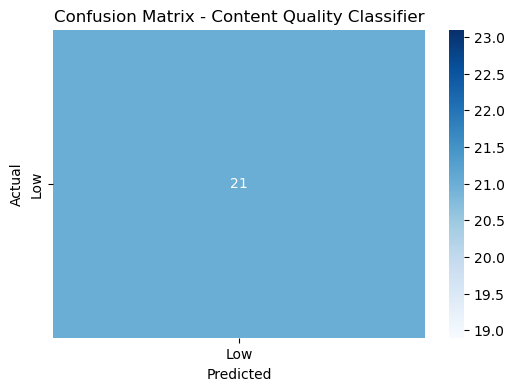


 Top Features:
 word_count             0.0
sentence_count         0.0
flesch_reading_ease    0.0
dtype: float64


In [77]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("../data/features_with_thin_flag.csv")

# duplicate
if 'word_count.1' in df.columns:
    df.drop('word_count.1', axis=1, inplace=True)

# ensure numeric types
df["flesch_reading_ease"] = pd.to_numeric(df["flesch_reading_ease"], errors="coerce").fillna(0)
df["word_count"] = pd.to_numeric(df["word_count"], errors="coerce").fillna(0)
df["sentence_count"] = pd.to_numeric(df["sentence_count"], errors="coerce").fillna(0)

#  generate Quality Labels
def label_quality(row):
    if (row["word_count"] > 1500) and (50 <= row["flesch_reading_ease"] <= 70):
        return "High"
    elif (row["word_count"] < 500) or (row["flesch_reading_ease"] < 30):
        return "Low"
    else:
        return "Medium"

df["quality_label"] = df.apply(label_quality, axis=1)

#  prepare training data
X = df[["word_count", "sentence_count", "flesch_reading_ease"]]
y = df["quality_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# evaluate Model
y_pred = model.predict(X_test)

print("\n classification Report:")
print(classification_report(y_test, y_pred))

print("Overall Accuracy:", round(accuracy_score(y_test, y_pred), 3))

#  Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='g',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Content Quality Classifier")
plt.show()

#  feature Importances
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n Top Features:\n", feature_importance)



In [78]:

#  save the model (optional)
import joblib
joblib.dump(model, "../models/quality_model.pkl")

print("\n Model trained and saved as models/quality_model.pkl")


 Model trained and saved as models/quality_model.pkl
